In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gymnasium.spaces import MultiDiscrete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.logger import pretty_print
import ray
# add our custom modules
#import sys, os
#sys.path.append("../src") # go to parent dir
from src.microgrid_env import MicrogridEnv

2023-10-07 17:53:01,802	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [3]:
env_df = pd.read_csv("../data/cropped.csv")
# FIXME: only take some columns that we can experiment
env_df = env_df.iloc[:100]

# names consistent with `update_environment`
env_df = env_df.rename(
  columns={"Wind Speed": "wind_speed",
           "Solar Irradiance": "solar_irradiance",
           "Grid Electricity Price": "rate_consumption_charge"},
)
# compute total energy demand from example houses
env_df["energy_demand"] = env_df["warehouse 1"] + env_df["small hotel 1"]
env_df = env_df.drop(columns=["warehouse 1", "small hotel 1"])

In [4]:
env_df

,wind_speed,solar_irradiance,rate_consumption_charge,energy_demand
0,45.900,0.1592,0.06,57.790509
1,46.872,0.0850,0.06,52.585363
2,47.340,0.0000,0.06,51.481020
3,40.608,0.0000,0.06,53.320262
4,42.732,0.0000,0.06,56.951506
...,...,...,...,...
95,7.488,0.0440,0.06,57.289176
96,6.156,0.0695,0.06,55.091547
97,5.148,0.0850,0.06,52.208000
98,3.312,0.0711,0.06,52.143701


In [5]:
data_dict = env_df.to_dict(orient="list")

In [6]:
env = MicrogridEnv(data_dict)

In [7]:
env.action_space.seed(42)
observation, info = env.reset(seed=42)

runs = [([],[])]
for epoch in range(500):
    action = env.action_space.sample() # TODO: this should probably come from our model
    observation, reward, terminated, truncated, info = env.step(action)
    runs[-1][0].append(observation)
    runs[-1][1].append(reward)
    
    if terminated or truncated:
        observation, info = env.reset()
        runs += [([], [])]

env.close()

In [8]:
len(runs)

6

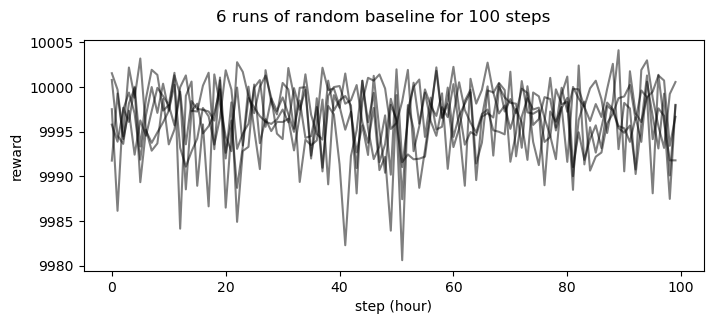

In [9]:
plt.figure(figsize=(8,3))
plt.suptitle("%d runs of random baseline for %d steps" % (len(runs), len(env_df)))
plt.xlabel("step (hour)")
plt.ylabel("reward")
for _, rewards in runs:
  plt.plot(rewards, c="k", alpha=.5)